# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [3]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [4]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [5]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(67, 6)


,title,price,year,link,brand,age
0,2003 honda crv,2500,2003.0,https://charlottesville.craigslist.org/cto/d/c...,honda,22.0
1,chevy hhr lt,10800,NaN,https://charlottesville.craigslist.org/cto/d/s...,chevy,NaN
2,lincoln continental mark vi,11500,NaN,https://charlottesville.craigslist.org/cto/d/w...,missing,NaN
3,for sale - used loaded 2005 gmc yukon denali,3750,2005.0,https://charlottesville.craigslist.org/cto/d/e...,gmc,20.0
4,1985 chevrolet 3/4 ton 4x4 short bed,26500,1985.0,https://charlottesville.craigslist.org/cto/d/s...,chevrolet,40.0


With the data in and wrangled, we can now do some analysis:

count       67.000000
mean      9906.641791
std      10615.776111
min       2000.000000
25%       3400.000000
50%       6500.000000
75%      11250.000000
max      62800.000000
Name: price, dtype: float64


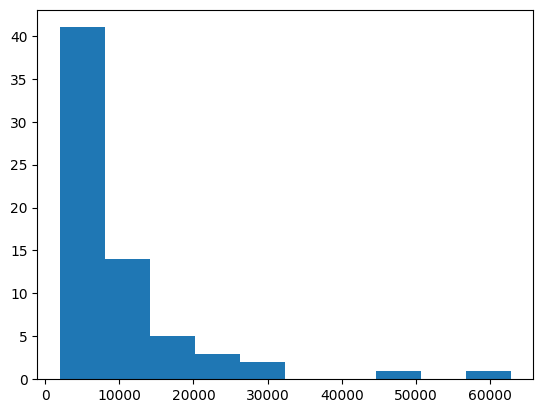

count    60.000000
mean     22.466667
std      14.632755
min       4.000000
25%      13.000000
50%      19.000000
75%      24.250000
max      68.000000
Name: age, dtype: float64


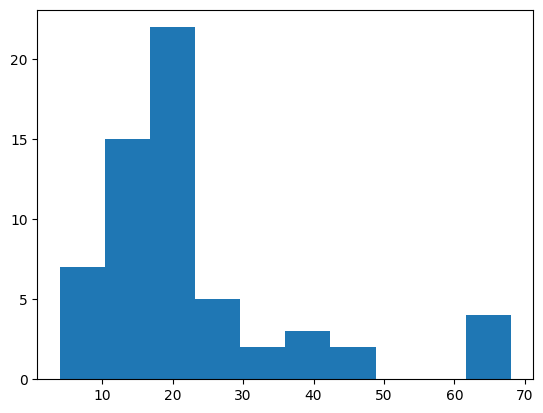

In [6]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [7]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   5250.000000   3181.980515   3000.0   4125.0   5250.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          3.0   9333.333333   1607.275127   7500.0   8750.0  10000.0   
cadillac     1.0   2950.000000           NaN   2950.0   2950.0   2950.0   
chevrolet    4.0  16362.500000   9061.399358   4950.0  12112.5  17000.0   
chevy        5.0   4980.000000   3566.791275   2200.0   2900.0   3000.0   
dodge        2.0   6875.000000   4065.863992   4000.0   5437.5   6875.0   
ford         6.0  18833.333333  15980.196077   4000.0  10500.0  15750.0   
gmc          3.0  12250.000000  12018.215342   3750.0   5375.0   7000.0   
honda       11.0   8427.272727   7880.366858   2500.0   3200.0   5900.0   
jeep         2.0   7475.000000   1732.411614   6250.0   6862.5   7475.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        1.0   3896.000000           NaN   3896.0   3896.0   3896.0   
missing     13.0  10096.153846  16937.968463   2000.0   3200.0   3500.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
subaru       1.0   5999.000000           NaN   5999.0   5999.0   5999.0   
tesla        1.0  25000.000000           NaN  25000.0  25000.0  25000.0   
toyota       6.0   8558.333333   4654.290136   3000.0   5525.0   8225.0   
volkswagen   3.0   7666.666667   5788.854233   2550.0   4525.0   6500.0   

                              
                75%      max  
brand                         
acura        6375.0   7500.0  
audi        11000.0  11000.0  
bmw         10250.0  10500.0  
cadillac     2950.0   2950.0  
chevrolet   21250.0  26500.0  
chevy        6000.0  10800.0  
dodge        8312.5   9750.0  
ford        18375.0  49500.0  
gmc         16500.0  26000.0  
honda       10450.0  29000.0  
jeep         8087.5   8700.0  
kia          2500.0   2500.0  
lexus        3896.0   3896.0  
missing      5250.0  62800.0  
mitsubishi   6800.0   6800.0  
subaru       5999.0   5999.0  
tesla       25000.0  25000.0  
toyota      10512.5  16000.0  
volkswagen  10225.0  13950.0

In [8]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          3.0  15.666667   1.527525  14.0  15.00  16.0  16.50  17.0
cadillac     1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
chevrolet    4.0  41.250000  19.619293  21.0  32.25  38.0  47.00  68.0
chevy        2.0  23.500000   3.535534  21.0  22.25  23.5  24.75  26.0
dodge        2.0  26.500000   6.363961  22.0  24.25  26.5  28.75  31.0
ford         6.0  19.666667   7.941452  11.0  14.00  19.5  22.00  33.0
gmc          2.0  30.500000  14.849242  20.0  25.25  30.5  35.75  41.0
honda       11.0  14.545455   6.022684   4.0  11.50  15.0  17.50  25.0
jeep         2.0  15.500000   3.535534  13.0  14.25  15.5  16.75  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
lexus        1.0  21.000000        NaN  21.0  21.00  21.0  21.00  21.0
missing     10.0  35.100000  22.859231   7.0  18.75  26.0  58.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
subaru       1.0  10.000000        NaN  10.0  10.00  10.0  10.00  10.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       6.0  18.333333   4.885352  12.0  14.75  19.0  21.00  25.0
volkswagen   3.0  25.333333  17.243356  10.0  16.00  22.0  33.00  44.0

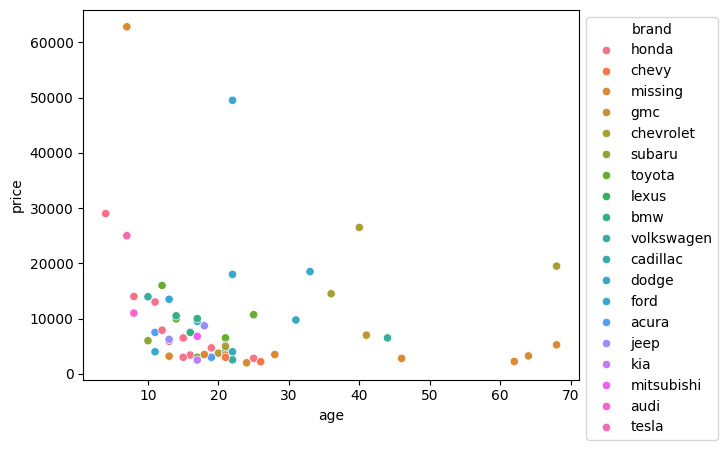

In [9]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.659961 -0.143808
log_age    -0.143808  0.328761
           log_price   log_age
log_price   1.000000 -0.310161
log_age    -0.310161  1.000000


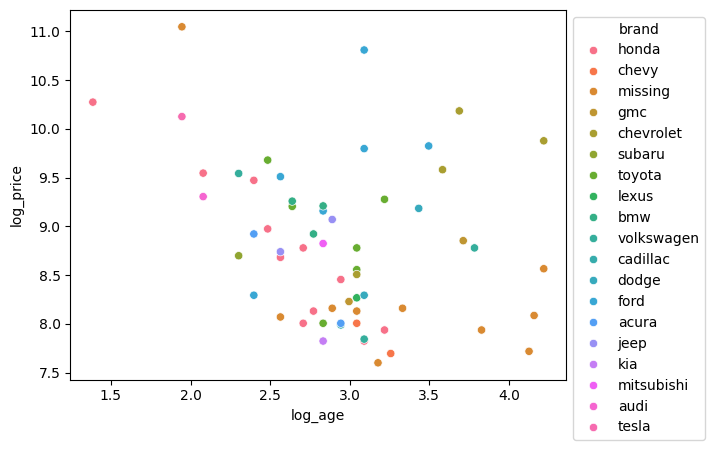

In [10]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime


URL = "https://charlottesville.craigslist.org/search/pet#search=1~list~0~38"


response = requests.get(URL)
soup = BeautifulSoup(response.text, "html.parser")
listings = []
for post in soup.find_all("li", class_="cl-static-search-result"):
    # print(post.prettify())
    title = post.find("div", class_="title").text.strip() if post.find("div", class_="title") else "No Title"
    # date = post.find("time")["datetime"] if post.find("time") else "No Date"
    location = post.find("div", class_="location").text.strip() if post.find("div", class_="location") else "No Location"
    # price = post.find("div", class_="price").text.strip() if post.find("div", class_="price") else "No Price"
    link = post.find("a")["href"] if post.find("a") else "No Link"
    listings.append({"Title": title, "Location": location, "URL": link})

df = pd.DataFrame(listings)

df.to_csv("craigslist_pets_listings_cleaned.csv", index=False)

df.head(20)


,Title,Location,URL
0,Lab mix.,Sco/Scottsville,https://charlottesville.craigslist.org/pet/d/s...
1,Rehoming Chocolate Lab,No Location,https://charlottesville.craigslist.org/pet/d/c...
2,Vivarium Electronics VE-200 stat Snake keepers...,No Location,https://charlottesville.craigslist.org/pet/d/b...
3,Need to get rid of this rooster asap,Keswick,https://charlottesville.craigslist.org/pet/d/k...
4,PVC Enclosures matching cabinet,Barboursville,https://charlottesville.craigslist.org/pet/d/b...
5,ISO orange cheek waxbill finch,No Location,https://charlottesville.craigslist.org/pet/d/s...
6,Bolivian Ram Cichlids + Doctor Garra fish,Charlottesville,https://charlottesville.craigslist.org/pet/d/c...
7,Anyone looking too sell there pet rat,Charlottesville,https://charlottesville.craigslist.org/pet/d/c...
8,Leopard geckos,Louisa,https://charlottesville.craigslist.org/pet/d/l...
9,Ball Python yearling for rehome,Charlottesville,https://charlottesville.craigslist.org/pet/d/b...


In [23]:
import time
descriptions = []
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
}
for url in df["URL"]:
    try:
        post_response = requests.get(url, headers=headers)
        post_soup = BeautifulSoup(post_response.text, "html.parser")
        desc_section = post_soup.find("section", id="postingbody")
        description = desc_section.text.strip() if desc_section else "No Description"
    except Exception as e:
        description = "Error retrieving post"
    descriptions.append(description)
    time.sleep(1) 

df["Description"] = descriptions


df.to_csv("craigslist_pets_full_listings.csv", index=False)
df.head(20)

,Title,Location,URL,Description
0,Lab mix.,Sco/Scottsville,https://charlottesville.craigslist.org/pet/d/s...,QR Code Link to This Post\n\n\n8 months old. F...
1,Rehoming Chocolate Lab,No Location,https://charlottesville.craigslist.org/pet/d/c...,QR Code Link to This Post\n\n\nIn search of a ...
2,Vivarium Electronics VE-200 stat Snake keepers...,No Location,https://charlottesville.craigslist.org/pet/d/b...,QR Code Link to This Post\n\n\nUsed about 7 mo...
3,Need to get rid of this rooster asap,Keswick,https://charlottesville.craigslist.org/pet/d/k...,QR Code Link to This Post\n\n\nThis is one of ...
4,PVC Enclosures matching cabinet,Barboursville,https://charlottesville.craigslist.org/pet/d/b...,QR Code Link to This Post\n\n\ntext for info
5,ISO orange cheek waxbill finch,No Location,https://charlottesville.craigslist.org/pet/d/s...,QR Code Link to This Post\n\n\nISO orange chee...
6,Bolivian Ram Cichlids + Doctor Garra fish,Charlottesville,https://charlottesville.craigslist.org/pet/d/c...,QR Code Link to This Post\n\n\nMy bolivian ram...
7,Anyone looking too sell there pet rat,Charlottesville,https://charlottesville.craigslist.org/pet/d/c...,QR Code Link to This Post\n\n\nI'm looking for...
8,Leopard geckos,Louisa,https://charlottesville.craigslist.org/pet/d/l...,QR Code Link to This Post\n\n\nLeopard geckos ...
9,Ball Python yearling for rehome,Charlottesville,https://charlottesville.craigslist.org/pet/d/b...,QR Code Link to This Post\n\n\nMale banana pas...


In [ ]:

animal_keywords = {
    "bird": ["rooster", "chicken", "parrot", "eagle", "sparrow", "finch","bird"],
    "reptile": ["python", "snake", "lizard", "gecko", "iguana","reptile","crocodile"],
    "cat": ["cat", "kitten", "feline"],
    "dog": ["dog", "puppy", "canine", "poodle", "bulldog, shepherd","lab","retriever"],
    "fish": ["fish", "goldfish", "guppy", "bass"],
    "rodent": ["hamster", "gerbil", "rodent", "guinea", "rat","chinchilla"],
    "rabbit": ["rabbit", "bunny", "hare"]
}


def classify_animal(title):
    title_lower = title.lower()
    for category, keywords in animal_keywords.items():
        if any(keyword in title_lower for keyword in keywords):

            return category

    return 'unknown'  


df["Animal Category"] = df["Title"].apply(classify_animal)
df.to_csv("craigslist_pets_full_listings.csv", index=False)

df.head(20)

,Title,Location,URL,Description,Animal Category
0,Lab mix.,Sco/Scottsville,https://charlottesville.craigslist.org/pet/d/s...,QR Code Link to This Post\n\n\n8 months old. F...,dog
1,Rehoming Chocolate Lab,No Location,https://charlottesville.craigslist.org/pet/d/c...,QR Code Link to This Post\n\n\nIn search of a ...,dog
2,Vivarium Electronics VE-200 stat Snake keepers...,No Location,https://charlottesville.craigslist.org/pet/d/b...,QR Code Link to This Post\n\n\nUsed about 7 mo...,reptile
3,Need to get rid of this rooster asap,Keswick,https://charlottesville.craigslist.org/pet/d/k...,QR Code Link to This Post\n\n\nThis is one of ...,bird
4,PVC Enclosures matching cabinet,Barboursville,https://charlottesville.craigslist.org/pet/d/b...,QR Code Link to This Post\n\n\ntext for info,unknown
5,ISO orange cheek waxbill finch,No Location,https://charlottesville.craigslist.org/pet/d/s...,QR Code Link to This Post\n\n\nISO orange chee...,bird
6,Bolivian Ram Cichlids + Doctor Garra fish,Charlottesville,https://charlottesville.craigslist.org/pet/d/c...,QR Code Link to This Post\n\n\nMy bolivian ram...,fish
7,Anyone looking too sell there pet rat,Charlottesville,https://charlottesville.craigslist.org/pet/d/c...,QR Code Link to This Post\n\n\nI'm looking for...,rodent
8,Leopard geckos,Louisa,https://charlottesville.craigslist.org/pet/d/l...,QR Code Link to This Post\n\n\nLeopard geckos ...,reptile
9,Ball Python yearling for rehome,Charlottesville,https://charlottesville.craigslist.org/pet/d/b...,QR Code Link to This Post\n\n\nMale banana pas...,reptile


In [25]:

df = pd.read_csv("craigslist_pets_full_listings.csv")

print("Total Listings:", len(df))

print(df["Location"].value_counts().head(10))


Total Listings: 24
Location
No Location          6
Charlottesville      6
Barboursville        4
Keswick              1
Sco/Scottsville      1
Louisa               1
Trevilians           1
Shipman              1
Madison, Virginia    1
DILLWYN              1
Name: count, dtype: int64


In [ ]:
import re
price_regex = r"\$\s*\d+(?:,\d{3})*(?:\.\d+)?"

def extract_price(text):
    if isinstance(text, str):
        match = re.search(price_regex, text)
        if match:
            price_str = match.group().replace("$", "").replace(" ", "").replace(",", "")
            try:
                return float(price_str)
            except ValueError:
                return None
    return None

df['extracted_price'] = df['Description'].apply(extract_price)
df.to_csv("craigslist_pets_full_listings.csv", index=False)

print(df.head(20))


                                                Title           Location  \
0                                            Lab mix.    Sco/Scottsville   
1                              Rehoming Chocolate Lab        No Location   
2   Vivarium Electronics VE-200 stat Snake keepers...        No Location   
3                Need to get rid of this rooster asap            Keswick   
4                     PVC Enclosures matching cabinet      Barboursville   
5                      ISO orange cheek waxbill finch        No Location   
6           Bolivian Ram Cichlids + Doctor Garra fish    Charlottesville   
7               Anyone looking too sell there pet rat    Charlottesville   
8                                      Leopard geckos             Louisa   
9                     Ball Python yearling for rehome    Charlottesville   
10                                        Guinea pigs      Barboursville   
11      Jumping Spider accessories Reduced $5 per set      Barboursville   
12          

/tmp/ipykernel_3878885/2946658869.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_prices, x="Animal Category", y="extracted_price", palette="viridis")


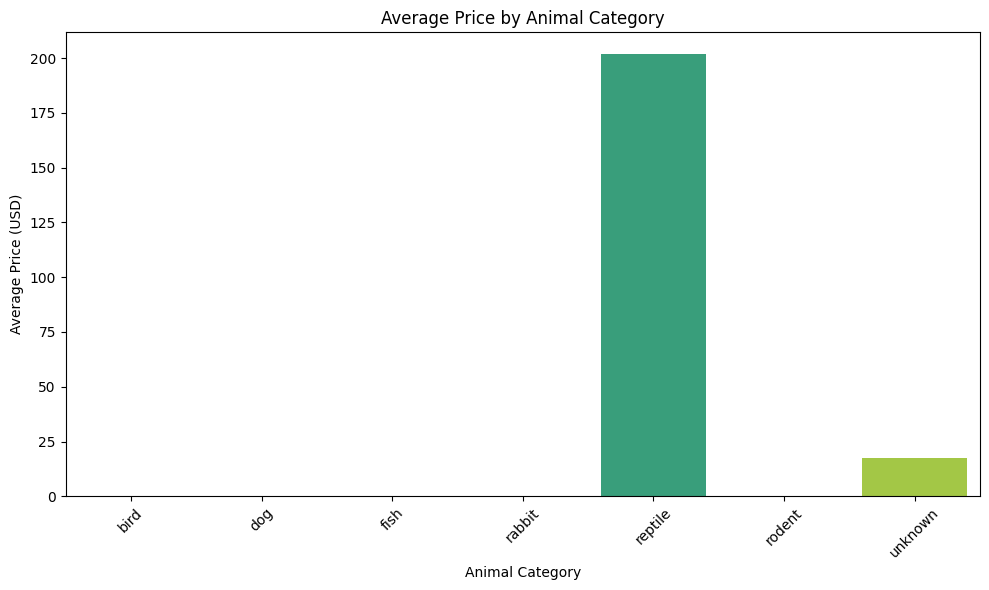

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

mean_prices = df.groupby("Animal Category")["extracted_price"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=mean_prices, x="Animal Category", y="extracted_price", palette="viridis")
plt.title("Average Price by Animal Category")
plt.xlabel("Animal Category")
plt.ylabel("Average Price (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The price was hard to find. When I tried to extract it from the listings, it just sadi $0 for each of them. So I had to go into the post and extract from the description to find the price. But this isn't very accurate either, because sometimes they say "free", but they also use it to say "feel free to ask", so I did not use that to make a price. But the number prices weren't always accurate either because sometimes they say retails for blank amount, and then ask for a different amount, or ask for a rehoming fee. Some people also weren't selling, but searching for a lost pet or wanting to buy a pet. So this was just a rudimentary way to try to find price. The reptiles seemed to be pretty expensive, while I might be able to assume that bird, dog, fish, rabbit, and rodent were either free or said rehoming fee. 

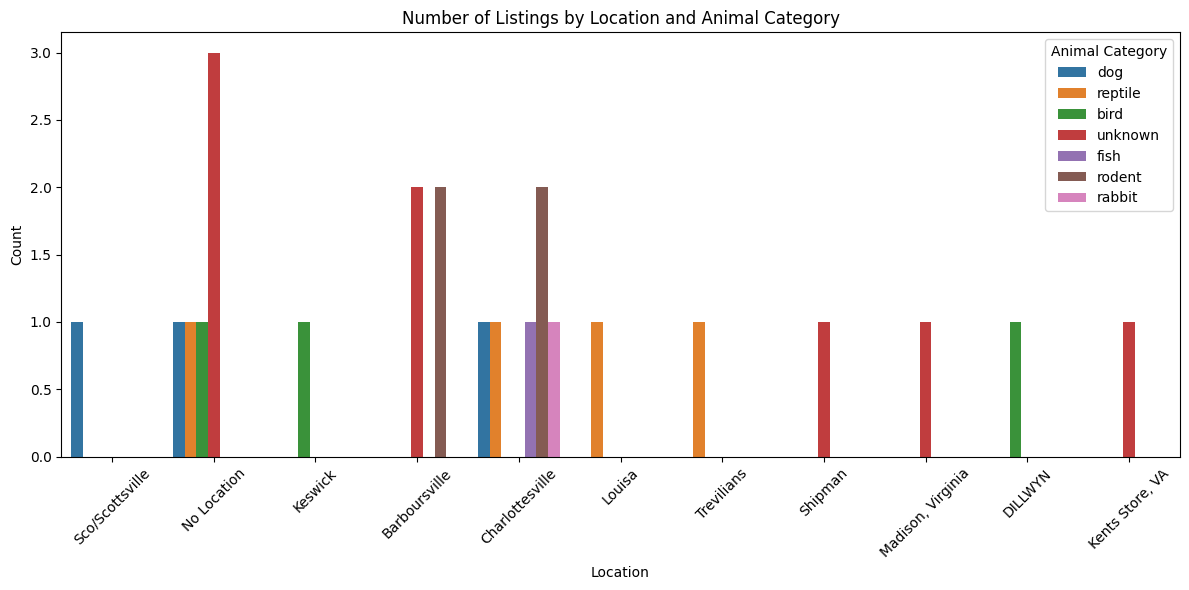

In [29]:


plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Location', hue='Animal Category')
plt.title("Number of Listings by Location and Animal Category")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Since I was in charlottesville location, most of the results are from charlottesville. But there are a decent amount of other locations including no location. I wanted to see if specific locations had a specific animal that was most common there, but I think the data set is too small to get any meaningful patterns.